<html>
<h1 style = "text-align : center; border : 1px black solid; padding : 20px; width:100%;"> DL. Task 2</h1>

<h5 style = "text-align : right;">Louis Salomé</h5>

<br>Here are the main parts of this notebook :
<ol>
<li>Load MNIST dataset</li>
<li>Train random forest classifier on train data. Evaluate models on test data. Use accuracy score as main evaluation metric</li>
<li>Train MLP on train data. Evaluate MLP on test data. Compare with previous results</li>
<li>Add random normal noise to train and test data. Then, repeat step #2 on noisy data</li>
<li>Train Simple (Non convolutional) Denoising Autoencoder and reconstruct data from data with noise. Repeat step #2 on reconstructed data.</li>
<li>Compare all results</li>
</ol>
</html>


In [1]:
### import part

# Process data
import numpy as np

# Plot graphics
import matplotlib
from matplotlib import pyplot as plt

# Measure time
import time
from time import time, mktime

#Simulate randomness
import random as rd

# Load Data
import keras
from keras.datasets.mnist import load_data

# Model selection
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Deep Learning
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import SGD
from keras.callbacks import TensorBoard

# Use only one of the 4 GPUs
# Using the command nvidia-sim we can chose the freest GPU
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Here is the NUMBER_OF_GPU
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


### 1. MINST dataset

MNIST database of handwritten digits
Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()
[m    ,h,w] = np.shape(x_train)
[mtest,h,w] = np.shape(x_test)
print("Train set :",m,"image of size",h,"x",w,".")
print("Test set  :",mtest,"image of size",h,"x",w,".")

Train set : 60000 image of size 28 x 28 .
Test set  : 10000 image of size 28 x 28 .


To use it in our models, we have to reshape these images of 28x28 pixels into vectors of shape 784x1. We also normalize the data as it is a good practice in machine learning to have values between in [0,1].

In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = keras.utils.normalize(x_train,axis=1)
x_test = keras.utils.normalize(x_test,axis=1)

x_train = np.reshape(x_train, (m, h*w))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (mtest, h*w))  # adapt this if using `channels_first` image data format

This is how an image of the dataset looks like :


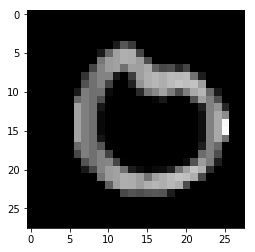

In [4]:
r = rd.randint(0,60000-1)
print("This is how an image of the dataset looks like :")
plt.imshow(x_train[r].reshape((h,w)), cmap='gray')
plt.show()

### 2. Random forest classifier

We first initialize our forest by setting its parameters.

In [5]:
RFtrainedOnOrginalData = RandomForestClassifier(
    n_estimators=100,
    criterion = 'gini')

Then we fit the classifier with x_train. If the amound of data is too big, this fitting can be quite long.

In [6]:
start=time()
RFtrainedOnOrginalData.fit(x_train, y_train)
print("Elapsed time for fitting : ", round(time()-start,2),"secondes.")

Elapsed time for fitting :  62.96 secondes.


We finally predict results for the testing set.

In [7]:
y_predict = RFtrainedOnOrginalData.predict(x_test)

Now we need an function to evaluate the accuracy of this prediction.

In [8]:
acc = accuracy_score(y_test, y_predict, normalize=True)
print("We found an accuracy of",round(100*acc,2),"%.")

We found an accuracy of 96.92 %.


### 3. Multi-layer Perceptron

We first initialize our classifier by setting its parameters.

Code inspired from youtube video : https://www.youtube.com/watch?v=wQ8BIBpya2k

In [9]:
# Architecture
MLPtrainedOnOriginalData = Sequential()
#model.add(Flatten())
MLPtrainedOnOriginalData.add(Dense(128, activation=tf.nn.relu, input_dim=h*w))
MLPtrainedOnOriginalData.add(Dense(64, activation=tf.nn.relu))
MLPtrainedOnOriginalData.add(Dense(10, activation=tf.nn.softmax))

# Compilation
MLPtrainedOnOriginalData.compile(
              optimizer='adam',
              loss='categorical_hinge',
              metrics=['accuracy'])
# model will be our mlp for the whole lab

# Training
start = time()
MLPtrainedOnOriginalData.fit(x_train, keras.utils.np_utils.to_categorical(y_train), epochs=20, batch_size=128)
print("Elapsed time for fitting : ", round(time()-start,2),"secondes.")

Epoch 1/20
60000/60000 [==============================] - 3s 44us/step - loss: 0.2952 - acc: 0.8759
Epoch 2/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.1297 - acc: 0.9406
Epoch 3/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.0999 - acc: 0.9543
Epoch 4/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.0819 - acc: 0.9628
Epoch 5/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.0700 - acc: 0.9680
Epoch 6/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.0612 - acc: 0.9719
Epoch 7/20
60000/60000 [==============================] - 2s 36us/step - loss: 0.0545 - acc: 0.9753
Epoch 8/20
60000/60000 [==============================] - 2s 35us/step - loss: 0.0482 - acc: 0.9778
Epoch 9/20
60000/60000 [==============================] - 2s 40us/step - loss: 0.0429 - acc: 0.9803
Epoch 10/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.0383 - acc: 0.9827

In [10]:
# Predicting
y_predict_onehot = MLPtrainedOnOriginalData.predict([x_test])
y_predict = np.zeros(mtest)
for i in range(mtest):
    y_predict[i] = np.argmax(y_predict_onehot[i])
    
# Calculating accuracy
acc = accuracy_score(y_predict,y_test)
print("We found an accuracy of",round(100*acc,2),"%.")

# Quicker & specific to keras :
# val_loss, val_acc = model.evaluate(x_test,y_test)
# print("We found an accuracy of",round(100*val_acc,2),"%.")

We found an accuracy of 97.29 %.


### 4. Noisy Data

In this part we are going to add some noise to the data and observe its consequence on the classification.

##### 4.1 Add noise on data

In [11]:
meanNoise = 0
stdNoise = 0.2 #This means that a typical noise will be +0.3 or -0.3 on every pixel
   
x_train_noisy = x_train + np.random.normal(loc=meanNoise, scale=stdNoise, size=x_train.shape) 
x_test_noisy  = x_test  + np.random.normal(loc=meanNoise, scale=stdNoise, size=x_test.shape) 

# The data must stay in [0,1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

This is how an image of the dataset looks like : (image number 16267 )


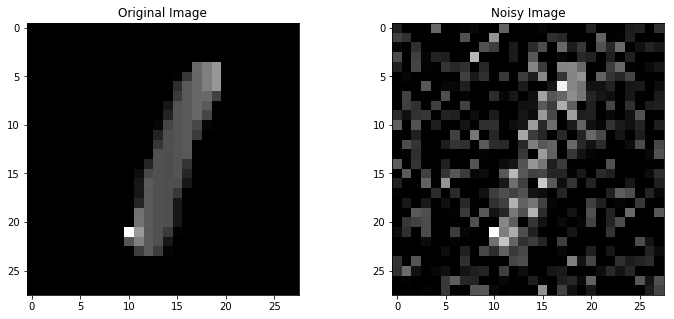

In [12]:
# Let's visualize our noisy data
r = rd.randint(0,60000-1)
print("This is how an image of the dataset looks like : (image number",r,")")
f, axarr = plt.subplots(1,2, figsize=(12,5))
axarr[0].imshow(x_train[r].reshape((h,w)), cmap='gray')
axarr[0].set_title("Original Image")
axarr[1].imshow(x_train_noisy[r].reshape((h,w)),cmap='gray')
axarr[1].set_title("Noisy Image")
plt.show()

Now let's do the same classification as before on this noisy dataset.

##### 4.2 Random forest classifier on noisy data

Same as section 2.

In [13]:
RFtrainedOnNoisyData = RandomForestClassifier(
    n_estimators=10,
    criterion = 'gini')
start=time()
RFtrainedOnNoisyData.fit(x_train_noisy, y_train)
print("Elapsed time for fitting : ", round(time()-start,2),"secondes.")
y_predict = RFtrainedOnNoisyData.predict(x_test)
acc = accuracy_score(y_predict,y_test)
print("We found an accuracy of",round(100*acc,2),"%.")

Elapsed time for fitting :  13.7 secondes.
We found an accuracy of 82.94 %.


##### 4.3 Multi-layer perceptron on noisy data

Same as section 3.

In [14]:
# Training on noisy data
# Architecture
MLPtrainedOnNoisyData = Sequential()
#model.add(Flatten())
MLPtrainedOnNoisyData.add(Dense(128, activation=tf.nn.relu, input_dim=h*w))
MLPtrainedOnNoisyData.add(Dense(64, activation=tf.nn.relu))
MLPtrainedOnNoisyData.add(Dense(10, activation=tf.nn.softmax))

# Compilation
MLPtrainedOnNoisyData.compile(
              optimizer='adam',
              loss='categorical_hinge',
              metrics=['accuracy'])
# model will be our mlp for the whole lab

# Training
start = time()
MLPtrainedOnNoisyData.fit(x_train_noisy, keras.utils.np_utils.to_categorical(y_train), epochs=20, batch_size=128)
print("Elapsed time for fitting : ", round(time()-start,2),"secondes.")

Epoch 1/20
60000/60000 [==============================] - 2s 40us/step - loss: 0.5530 - acc: 0.7370
Epoch 2/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.2872 - acc: 0.8674
Epoch 3/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.2437 - acc: 0.8849
Epoch 4/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.2191 - acc: 0.8966
Epoch 5/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.1984 - acc: 0.9056
Epoch 6/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.1822 - acc: 0.9139
Epoch 7/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.1698 - acc: 0.9193
Epoch 8/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.1562 - acc: 0.9262
Epoch 9/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.1462 - acc: 0.9302
Epoch 10/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.1381 - acc: 0.9344

In [15]:
# Predicting
y_predict_onehot = MLPtrainedOnNoisyData.predict([x_test])
y_predict = np.zeros(mtest)
for i in range(mtest):
    y_predict[i] = np.argmax(y_predict_onehot[i])
    
# Calculating accuracy
acc = accuracy_score(y_predict,y_test)
print("We found an accuracy of",round(100*acc,2),"%.")

We found an accuracy of 94.55 %.


### 5. Denoising autoencoder

In this part we are going to reduce the noise we added before so that we find a smoother version than original data without too much noise.

##### 5.1 Building an autoencoder

Code from : https://blog.keras.io/building-autoencoders-in-keras.html

We first build the architecture of the autoencoder.

In [16]:
# This algorithm was designed for a four-dimension dataset.
x_train = np.reshape(x_train, (m    , 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test  = np.reshape(x_test , (mtest, 28, 28, 1))  # adapt this if using `channels_first` image data format 

x_train_noisy = np.reshape(x_train_noisy, (m    , 28, 28, 1))
x_test_noisy  = np.reshape(x_test_noisy , (mtest, 28, 28, 1))

In [17]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Then we can train it.

In [18]:
start=time()
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test)
                #callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)]
               )
print("Elapsed time for fitting :", round(time()-start,2),"secondes.")

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 95us/step - loss: 0.1542 - val_loss: 0.1242
Epoch 2/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.1206 - val_loss: 0.1205
Epoch 3/20
60000/60000 [==============================] - 5s 78us/step - loss: 0.1179 - val_loss: 0.1181
Epoch 4/20
60000/60000 [==============================] - 5s 78us/step - loss: 0.1166 - val_loss: 0.1173
Epoch 5/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.1159 - val_loss: 0.1161
Epoch 6/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.1153 - val_loss: 0.1156
Epoch 7/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.1150 - val_loss: 0.1155
Epoch 8/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.1146 - val_loss: 0.1150
Epoch 9/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.1144 - val_loss: 0.1149
Epoch

Now we can produce our new denoised data.

In [19]:
x_train_denoised = autoencoder.predict(x_train_noisy)
x_test_denoised = autoencoder.predict(x_test_noisy)

In [20]:
x_train = np.reshape(x_train, (m    , h*w)) 
x_test  = np.reshape(x_test , (mtest, h*w))
x_train_noisy = np.reshape(x_train_noisy, (m    , h*w)) 
x_test_noisy  = np.reshape(x_test_noisy , (mtest, h*w))
x_train_denoised = np.reshape(x_train_denoised, (m    , h*w)) 
x_test_denoised  = np.reshape(x_test_denoised , (mtest, h*w))

This is how an image of the dataset looks like : (image number 34018 )


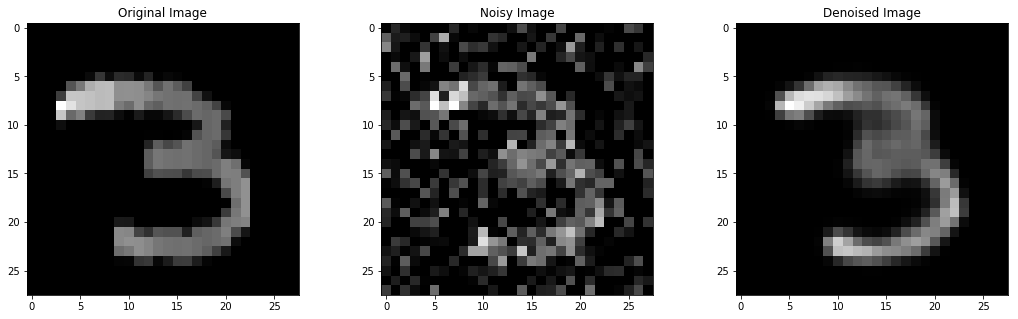

In [21]:
# Run this cell to look at a new image !
r = rd.randint(0,60000-1)
print("This is how an image of the dataset looks like : (image number",r,")")
f, axarr = plt.subplots(1,3, figsize=(18,5))
axarr[0].imshow(x_train[r].reshape((h,w)), cmap='gray')
axarr[0].set_title("Original Image")
axarr[1].imshow(x_train_noisy[r].reshape((h,w)),cmap='gray')
axarr[1].set_title("Noisy Image")
axarr[2].imshow(x_train_denoised[r].reshape((h,w)),cmap='gray')
axarr[2].set_title("Denoised Image")
plt.show()

##### 5.2 Random forest classifier on denoised data

Same as section 2.

In [22]:
RFtrainedOnDenoisedData = RandomForestClassifier(
    n_estimators=100,
    criterion = 'gini')
start=time()
RFtrainedOnDenoisedData.fit(x_train_denoised, y_train)
print("Elapsed time for fitting : ", round(time()-start,2),"secondes.")
y_predict = RFtrainedOnDenoisedData.predict(x_test)
acc = accuracy_score(y_predict,y_test)
print("We found an accuracy of",round(100*acc,2),"%.")

Elapsed time for fitting :  214.27 secondes.
We found an accuracy of 90.58 %.


##### 5.3 Multi-layer perceptron on denoised data

Same as section 3.

In [23]:
# Training on denoised data
# Architecture
MLPtrainedOnDenoisedData = Sequential()
#model.add(Flatten())
MLPtrainedOnDenoisedData.add(Dense(128, activation=tf.nn.relu, input_dim=h*w))
MLPtrainedOnDenoisedData.add(Dense(64, activation=tf.nn.relu))
MLPtrainedOnDenoisedData.add(Dense(10, activation=tf.nn.softmax))

# Compilation
MLPtrainedOnDenoisedData.compile(
              optimizer='adam',
              loss='categorical_hinge',
              metrics=['accuracy'])
# model will be our mlp for the whole lab

# Training
start = time()
MLPtrainedOnDenoisedData.fit(x_train_denoised, keras.utils.np_utils.to_categorical(y_train), epochs=20, batch_size=128)
print("Elapsed time for fitting : ", round(time()-start,2),"secondes.")

Epoch 1/20
60000/60000 [==============================] - 2s 41us/step - loss: 0.3355 - acc: 0.8568
Epoch 2/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.1766 - acc: 0.9175
Epoch 3/20
60000/60000 [==============================] - 3s 42us/step - loss: 0.1482 - acc: 0.9297
Epoch 4/20
60000/60000 [==============================] - 2s 39us/step - loss: 0.1306 - acc: 0.9381
Epoch 5/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.1186 - acc: 0.9439
Epoch 6/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.1089 - acc: 0.9481
Epoch 7/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.1003 - acc: 0.9526
Epoch 8/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.0927 - acc: 0.9563
Epoch 9/20
60000/60000 [==============================] - 2s 37us/step - loss: 0.0878 - acc: 0.9587
Epoch 10/20
60000/60000 [==============================] - 2s 38us/step - loss: 0.0830 - acc: 0.9612

In [24]:
# Predicting
y_predict_onehot = MLPtrainedOnDenoisedData.predict([x_test])
y_predict = np.zeros(mtest)
for i in range(mtest):
    y_predict[i] = np.argmax(y_predict_onehot[i])
    
# Calculating accuracy
acc = accuracy_score(y_predict,y_test)
print("We found an accuracy of",round(100*acc,2),"%.")

# Quicker & specific to keras :
# val_loss, val_acc = model.evaluate(x_test,y_test)
# print("We found an accuracy of",round(100*val_acc,2),"%.")

We found an accuracy of 96.88 %.


### 6. Conclusion

To sum up, we trained 2 models of Machine Learning on 3 differents types of data :
<ul>
    <li>The original data</li>
    <li>The noisy data</li>
    <li>The denoised data</li>
</ul>

Now we will see how good these differents models are to make predictions on the 3 differents types of test datasets.

In [25]:
accRForginalXoriginal = round(100*accuracy_score(RFtrainedOnOrginalData.predict(x_test),y_test),3)
accRForginalXnoisy    = round(100*accuracy_score(RFtrainedOnOrginalData.predict(x_test_noisy),y_test),3)
accRForginalXdenoised = round(100*accuracy_score(RFtrainedOnOrginalData.predict(x_test_denoised),y_test),3)

accRFnoisyXoriginal  = round(100*accuracy_score(RFtrainedOnNoisyData.predict(x_test),y_test),3)
accRFnoisyXnoisy     = round(100*accuracy_score(RFtrainedOnNoisyData.predict(x_test_noisy),y_test),3)
accRFnoisylXdenoised = round(100*accuracy_score(RFtrainedOnNoisyData.predict(x_test_denoised),y_test),3)

accRFdenoisedXoriginal  = round(100*accuracy_score(RFtrainedOnDenoisedData.predict(x_test),y_test),3)
accRFdenoisedXnoisy     = round(100*accuracy_score(RFtrainedOnDenoisedData.predict(x_test_noisy),y_test),3)
accRFdenoisedlXdenoised = round(100*accuracy_score(RFtrainedOnDenoisedData.predict(x_test_denoised),y_test),3)

In [26]:
MLPtrainedOnOriginalData.evaluate(x_test, keras.utils.np_utils.to_categorical(y_test))

10000/10000 [==============================] - 1s 52us/step


[0.056127648037672041, 0.97289999999999999]

In [27]:
accMLPorginalXoriginal = round(100*MLPtrainedOnOriginalData.evaluate(x_test, keras.utils.np_utils.to_categorical(y_test))[1],2)
accMLPorginalXnoisy    = round(100*MLPtrainedOnOriginalData.evaluate(x_test_noisy,keras.utils.np_utils.to_categorical(y_test))[1],2)
accMLPorginalXdenoised = round(100*MLPtrainedOnOriginalData.evaluate(x_test_denoised,keras.utils.np_utils.to_categorical(y_test))[1],2)

accMLPnoisyXoriginal  = round(100*MLPtrainedOnNoisyData.evaluate(x_test, keras.utils.np_utils.to_categorical(y_test))[1],2)
accMLPnoisyXnoisy     = round(100*MLPtrainedOnNoisyData.evaluate(x_test_noisy,keras.utils.np_utils.to_categorical(y_test))[1],2)
accMLPnoisylXdenoised = round(100*MLPtrainedOnNoisyData.evaluate(x_test_denoised,keras.utils.np_utils.to_categorical(y_test))[1],2)

accMLPdenoisedXoriginal  = round(100*MLPtrainedOnDenoisedData.evaluate(x_test,keras.utils.np_utils.to_categorical(y_test))[1],2)
accMLPdenoisedXnoisy     = round(100*MLPtrainedOnDenoisedData.evaluate(x_test_noisy,keras.utils.np_utils.to_categorical(y_test))[1],2)
accMLPdenoisedlXdenoised = round(100*MLPtrainedOnDenoisedData.evaluate(x_test_denoised,keras.utils.np_utils.to_categorical(y_test))[1],2)

10000/10000 [==============================] - 1s 50us/step


In [30]:
print("                             |","Orginal Data    |","Noisy Data    |","Denoised Data    |")
print("RF  trained on original Data |",accRForginalXoriginal,"%         |",accRForginalXnoisy,"%       |",accRForginalXdenoised,"%          |")
print("RF  trained on noisy Data    |",accRFnoisyXoriginal,"%         |",accRFnoisyXnoisy,"%       |",accRFnoisylXdenoised,"%          |")
print("RF  trained on denoised Data |",accRFdenoisedXoriginal,"%         |",accRFdenoisedXnoisy,"%       |",accRFdenoisedlXdenoised,"%          |")
print("                             |----------------------------------------------------|")
print("MLP trained on original Data |",accMLPorginalXoriginal,"%         |",accMLPorginalXnoisy,"%       |",accMLPorginalXdenoised,"%          |")
print("MLP trained on noisy Data    |",accMLPnoisyXoriginal,"%         |",accMLPnoisyXnoisy,"%       |",accMLPnoisylXdenoised,"%          |")
print("MLP trained on denoised Data |",accMLPdenoisedXoriginal,"%         |",accMLPdenoisedXnoisy,"%       |",accMLPdenoisedlXdenoised,"%          |")

                             | Orginal Data    | Noisy Data    | Denoised Data    |
RF  trained on original Data | 96.92 %         | 50.09 %       | 88.82 %          |
RF  trained on noisy Data    | 82.94 %         | 60.94 %       | 79.17 %          |
RF  trained on denoised Data | 90.58 %         | 51.39 %       | 94.01 %          |
                             |----------------------------------------------------|
MLP trained on original Data | 97.29 %         | 56.06 %       | 94.61 %          |
MLP trained on noisy Data    | 94.55 %         | 90.51 %       | 91.64 %          |
MLP trained on denoised Data | 96.88 %         | 51.19 %       | 95.21 %          |


Now let's draw conclusions. We should not compare directly RF and MLP because each classifier can be improved by setting some parameters (e.g. Use a bigger forest, set a max_depth or use a bigger NN, increase the number of epochs...).

First, about RF :
<ul>
    <li>The best score is reached with the RF trained on original data and used on original data, the mst classic one.</li>
    <li>We can say that the RF are always bad when the data is too noisy. Even the one trained on noisy data is bad.</li>
</ul>

Then, about MLP :
<ul>
    <li>The first thing we notice is that the best of them all to predict y_test is the MLP trained on orginal data.
However, this one is very bad at classifying noisy data. It has never seen a noisy image so it's lost when it has to deal with noisy data.</li>
    <li>The MLP trained on noisy data is really interesting because it has great score on every types of data. It is very good in average. So this might be the one we should use if we really don't know what kind of data will come next.</li>
    <li>The MLP trained on denoised data has two very high scores on original and denoised data. Even if it can't understand noisy image, it is maybe the one which understands the most important features of an image of number. We can suppose that some artefacts of the original data were detected as important features by the other algorithms, but it was a mistake to give importance to it. The noise made these particularities disappear by smoothing the data, uniformizing it.</li>
</ul>

Among all these facts, I think that the most interesting one is that the MLP trained on denoised data had a better score on original data than on denoised data, and this one is really high. By learning on smooth and fuzzy data, it must have a very small overfitting on the original dataset. The final score on original data is pretty close to the best one. We can suppose that the mistakes that this algorithms makes are more "human" than the mistakes of the others algorithms. It just learned the global idea of the shape of each number and not just focused on some specific artefacts.